In [253]:
import numpy as np
import scipy.spatial as spt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=[0.3,0.6,0.5],
                  shuffle=True,
                  random_state=0)
print(X[0:5,:])
print(y)

[[ 2.71506328  1.2908219 ]
 [ 0.70993435  3.70954839]
 [ 0.87189643  4.35069202]
 [ 0.70763011  4.41985808]
 [ 2.73124907  0.24970475]]
[1 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 1 2 1 0 1 0 0 2 1 1 0 2 1 2 2 2 2 0 1 1
 1 0 0 2 2 0 1 1 1 2 0 2 0 1 0 0 1 1 2 0 1 2 0 2 2 2 2 0 2 0 1 0 0 0 1 1 0
 1 0 0 2 2 0 1 1 0 0 1 1 1 2 2 1 1 0 1 0 1 0 2 2 1 1 1 1 2 1 1 0 2 0 0 0 2
 0 1 2 0 2 0 0 2 2 0 1 0 0 1 1 2 1 2 2 2 2 1 2 2 2 0 2 1 2 0 0 1 1 2 2 2 2
 1 1]


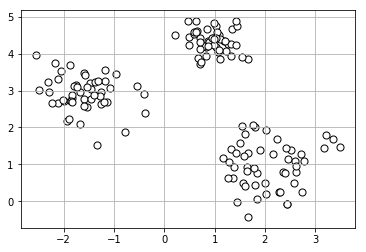

In [254]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0],
            X[:, 1],
            c='white',
            marker='o',
            edgecolors='black',
            s=50)
plt.grid()
plt.show()

In [260]:
def kmeans(X,
           eta=0.1,
           n_clusters=1,
           n_iter=1,
           max_iter=100,
           tol=1e-6,
           random_state=None):
    np.random.seed(random_state)
    
    # Initialize centroids to n_clusters random data points
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    
    for i in range(max_iter):
        # Calculate the distance between each data point and centroid
        distances = spt.distance.cdist(X, centroids, 'euclidean')
        
        # Calculate the index of the closest centroid
        fit = np.argmin(distances, axis=1)
        
        # Update the centroid values
        for k in range(n_clusters):
            for n in range(X.shape[1]):
                centroids[k][n] = centroids[k][n] + eta * (np.mean(X[k == fit][:,n]) - centroids[k][n])
    return fit, centroids

In [267]:
y_km, centroids_km = kmeans(X, eta=0.1, n_clusters=3, random_state=0)
print("y_km =\n", y_km)
print("centroids_km =\n", centroids_km)

y_km =
 [1 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 1 2 1 0 1 0 0 2 1 1 0 2 1 2 2 2 2 0 1 1
 1 0 0 2 2 0 1 1 1 2 0 2 0 1 0 0 1 1 2 0 1 2 0 2 2 2 2 0 2 0 1 0 0 0 1 1 0
 1 0 0 2 2 0 1 1 0 0 1 1 1 2 2 1 1 0 1 0 1 0 2 2 1 1 1 1 2 1 1 0 2 0 0 0 2
 0 1 2 0 2 0 0 2 2 0 1 0 0 1 1 2 1 2 2 2 2 1 2 2 2 0 2 1 2 0 0 1 1 2 2 2 2
 1 1]
centroids_km =
 [[ 0.95030937  4.33401232]
 [ 2.06704246  0.97418652]
 [-1.59474542  2.92238621]]


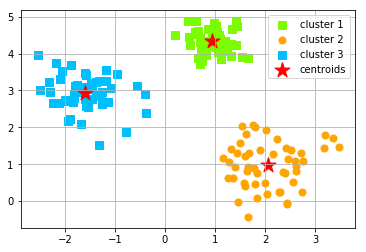

In [268]:
plt.clf()
plt.scatter(X[y_km==0, 0],
            X[y_km==0, 1],
            s=50,
            c='lawngreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km==1, 0],
            X[y_km==1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km==2, 0],
            X[y_km==2, 1],
            s=50,
            c='deepskyblue',
            marker='s',
            label='cluster 3')
plt.scatter(centroids_km[:, 0],
            centroids_km[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.show()

In [269]:
def gaussianMixture(X,
                    eta=0.1,
                    n_components=1,
                    tol=1e-6,
                    max_iter=100,
                    n_init=10,
                    means_init=None,
                    random_state=None):
    # Initialize means
    if means_init == None:
        y_km, centroids = kmeans(X, eta=eta, n_clusters=n_components, random_state=random_state)
    else:
        centroids = means_init
    
    # Initialize covariances
    # Initialize mixing coefficients

    
#gmm.fit(X)
#y_gmm = gmm.predict(X)
#print(y_gmm)
#print(gmm.means_)

In [270]:
gaussianMixture(X, eta=0.1, n_components=3, means_init=centroids_km, random_state=0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()